<a href="https://colab.research.google.com/github/cielcs/Bayesian-inference/blob/main/%E3%82%AC%E3%82%A6%E3%82%B9%E9%81%8E%E7%A8%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ガウス過程の基礎的なコード

In [5]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.stats import norm

# 観測データ
observed_data = np.array([
    [1.0, 1.0], [1.0, 1.2], [1.0, 0.8],
    [2.0, 2.0], [2.0, 2.1], [2.0, 1.9],
    [3.0, 3.0], [3.0, 3.1], [3.0, 2.9]
])

# 観測時間と値を分離
X = observed_data[:, 0].reshape(-1, 1)
y = observed_data[:, 1]

# GPRモデルの構築
# カーネルとして定数カーネルとRBFカーネルの積を使用
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# モデルのフィッティング
gp.fit(X, y)

# 新しい時間点
new_times = np.array([10, 2.5, 3.5,5,4]).reshape(-1, 1)

# 新しい時間点に対する予測
y_pred, sigma = gp.predict(new_times, return_std=True)

# 新しいデータポイントの尤度計算
likelihoods = norm.pdf(new_times.flatten(), loc=y_pred, scale=sigma)

print(f"新しい時間点 {new_times.flatten()} の予測値: {y_pred}")
print(f"新しい時間点 {new_times.flatten()} の予測不確実性 (標準偏差): {sigma}")
print(f"新しい時間点 {new_times.flatten()} の尤度: {likelihoods}")


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


新しい時間点 [10.   2.5  3.5  5.   4. ] の予測値: [9.9624784  2.49963585 3.49963585 4.99799132 3.99902234]
新しい時間点 [10.   2.5  3.5  5.   4. ] の予測不確実性 (標準偏差): [8.85305064e-03 8.21766278e-06 3.55219680e-05 4.26501051e-04
 1.08532055e-04]
新しい時間点 [10.   2.5  3.5  5.   4. ] の尤度: [5.66526371e-03 0.00000000e+00 1.69658206e-19 1.42713592e-02
 8.80780644e-15]


応用

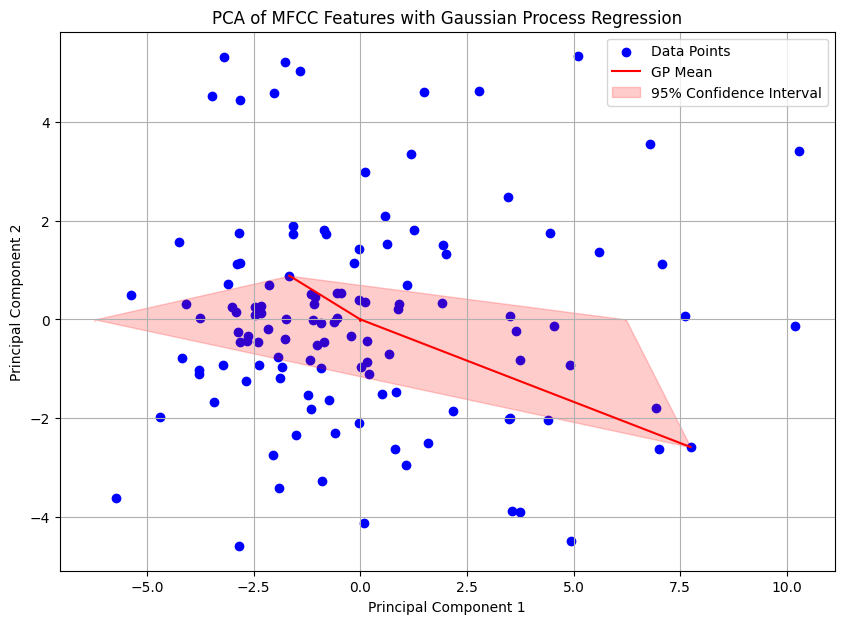

In [7]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# ディレクトリのパス
directory = '/content/drive/MyDrive/naist/Bsound/'

# 指定された時刻のリスト（文字列として）
specified_times = ['5_29_1710', '5_29_2235','5_30_1337','5_30_1359','5_31_2144','6_1_1806','6_2_1505','6_4_1500','6_5_1842','6_7_1602','6_21_1905','6_23_0132','7_3_1833','7_4_1049','7_5_0306']

def parse_time(time_str):
    return datetime.strptime(time_str, '%m_%d_%H%M')

def calculate_minutes_difference(time1, time2):
    delta = time2 - time1
    return int(delta.total_seconds() / 60)

def extract_mfcc_features(audio_path, n_mfcc=13):
    y, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfccs.T, axis=0)
    mfcc_var = np.std(mfccs.T, axis=0)
    return np.concatenate((mfcc_mean, mfcc_var))

def process_directory(directory, specified_times):
    mfcc_list = []
    labels = []
    times = []
    specified_datetimes = [parse_time(time_str) for time_str in specified_times]

    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            base_name = os.path.splitext(filename)[0]
            file_time = parse_time(base_name)
            times.append(file_time)
            mfccs = extract_mfcc_features(file_path)
            mfcc_list.append(mfccs)

    return np.array(mfcc_list), times

# MFCCを抽出
mfcc_features, times = process_directory(directory, specified_times)

# データの標準化
scaler = StandardScaler()
mfcc_features_normalized = scaler.fit_transform(mfcc_features)

# PCAを実行
pca = PCA(n_components=2)
mfcc_pca = pca.fit_transform(mfcc_features_normalized)

# 時間データを数値データに変換
start_time = min(times)
time_differences = np.array([calculate_minutes_difference(start_time, t) for t in times]).reshape(-1, 1)

# GPRモデルの構築
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# PCA成分ごとにガウス過程を適用
gp.fit(time_differences, mfcc_pca[:, 0])
y_pred_1, sigma_1 = gp.predict(time_differences, return_std=True)

gp.fit(time_differences, mfcc_pca[:, 1])
y_pred_2, sigma_2 = gp.predict(time_differences, return_std=True)

# プロット
fig, ax = plt.subplots(figsize=(10, 7))

# データポイントのプロット
sc = ax.scatter(mfcc_pca[:, 0], mfcc_pca[:, 1], c='blue', label='Data Points')

# ガウス過程の予測分布をプロット
time_grid = np.linspace(min(time_differences), max(time_differences), 100).reshape(-1, 1)

gp.fit(time_differences, mfcc_pca[:, 0])
y_pred_1_grid, sigma_1_grid = gp.predict(time_grid, return_std=True)

gp.fit(time_differences, mfcc_pca[:, 1])
y_pred_2_grid, sigma_2_grid = gp.predict(time_grid, return_std=True)

ax.plot(y_pred_1_grid, y_pred_2_grid, 'r', label='GP Mean')
ax.fill_betweenx(y_pred_2_grid, y_pred_1_grid - 1.96 * sigma_1_grid, y_pred_1_grid + 1.96 * sigma_1_grid, color='r', alpha=0.2, label='95% Confidence Interval')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA of MFCC Features with Gaussian Process Regression')
ax.legend()
ax.grid(True)
plt.show()
